In [57]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker

from dataset import Dataset

import mpl_toolkits.mplot3d  # noqa: F401
from sklearn import manifold, datasets

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
from diffusion_map import DiffusionMap
from datafold.utils.plot import plot_pairwise_eigenvector

In [58]:
def plot_eigenfunctions(n_evecs, nr_samples, nr_samples_plot, part, evecs, evals, time):
    """
    Plot different graphs with respect to selected part.
    """
    # print(f"{n_evecs} Largest eigenvalues with respect this dataset: \n {evals}")
    idx_plot = np.random.permutation(nr_samples)[0:nr_samples_plot]

    if part == 1 or part == 2:
        plot_pairwise_eigenvector(
            eigenvectors=evecs[idx_plot, :],
            n=1,
            fig_params=dict(figsize=[15, 15]),
            scatter_params=dict(cmap=plt.cm.Spectral, c=time[idx_plot],s=0.5)
        ) 
    elif part == 3:
        pass
    
    plt.show()


SyntaxError: invalid syntax (<ipython-input-58-24f3d9263d3e>, line 5)

## Initializations:

In [6]:
nr_samples = 10000        # Number of samples
nr_samples_plot = 2000    # Number of samples to plot
n_evecs = 10              # L+1 largest eigenfunctions
radius = 5                # Radius around a point for distance computation

### Make Swiss-roll Data Set

In [7]:
part = 1

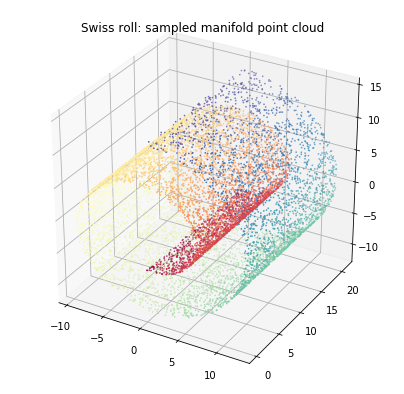

In [8]:
dataset = Dataset(nr_samples, nr_samples_plot)
positions, positions_color = dataset.generate_swiss_roll()
dataset.plot_swiss_roll(positions, positions_color)


### Part 1: Swiss-roll Data set embedding using our Diffusion Map

10 Largest eigenvalues with respect this dataset: 
 [1.         0.99969597 0.99878004 0.99724945 0.99516994 0.99483859
 0.99453064 0.99361172 0.99240406 0.99207065 0.99005612]


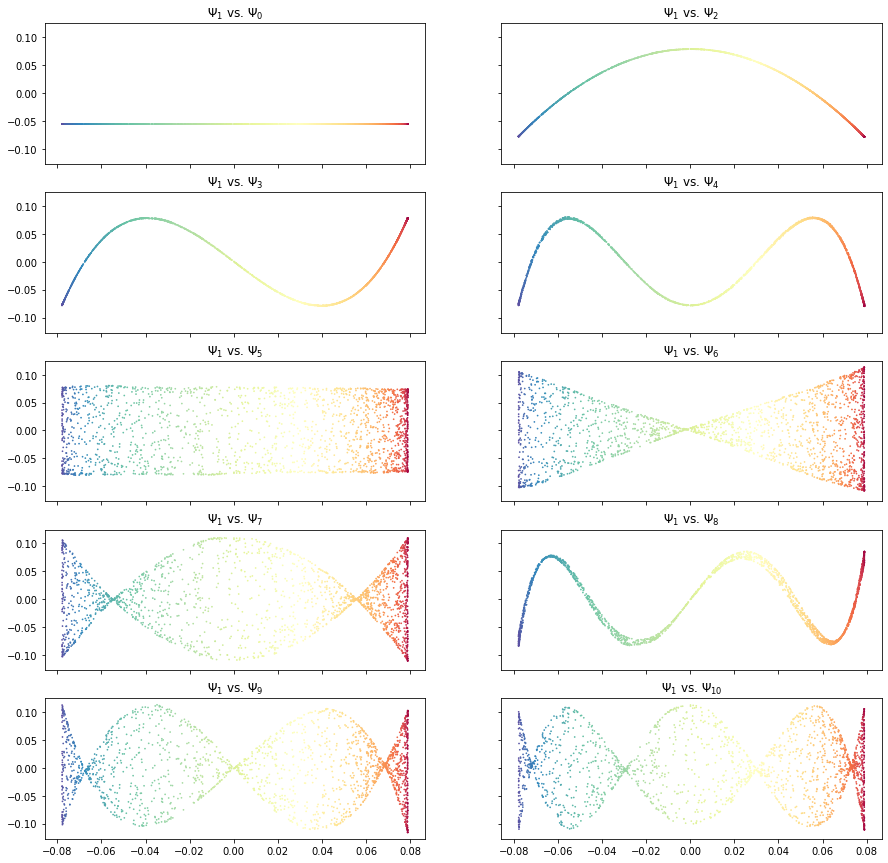

In [12]:
dmap = DiffusionMap()
evecs, evals = dmap.compute_eigenfunctions(positions, n_evecs, radius)

# Plot the eigenfunction phi_1 with respect to the others
plot_eigenfunctions(n_evecs, nr_samples, nr_samples_plot, part, evecs, evals, positions_color)

## Part 2: Swiss-roll Data set embedding using DataFold Library

In [17]:
part = 2

10 Largest eigenvalues with respect this dataset: 
 [1.         0.99985228 0.99940449 0.99867289 0.99765286 0.99746451
 0.99718984 0.99678904 0.99631959 0.99608489]


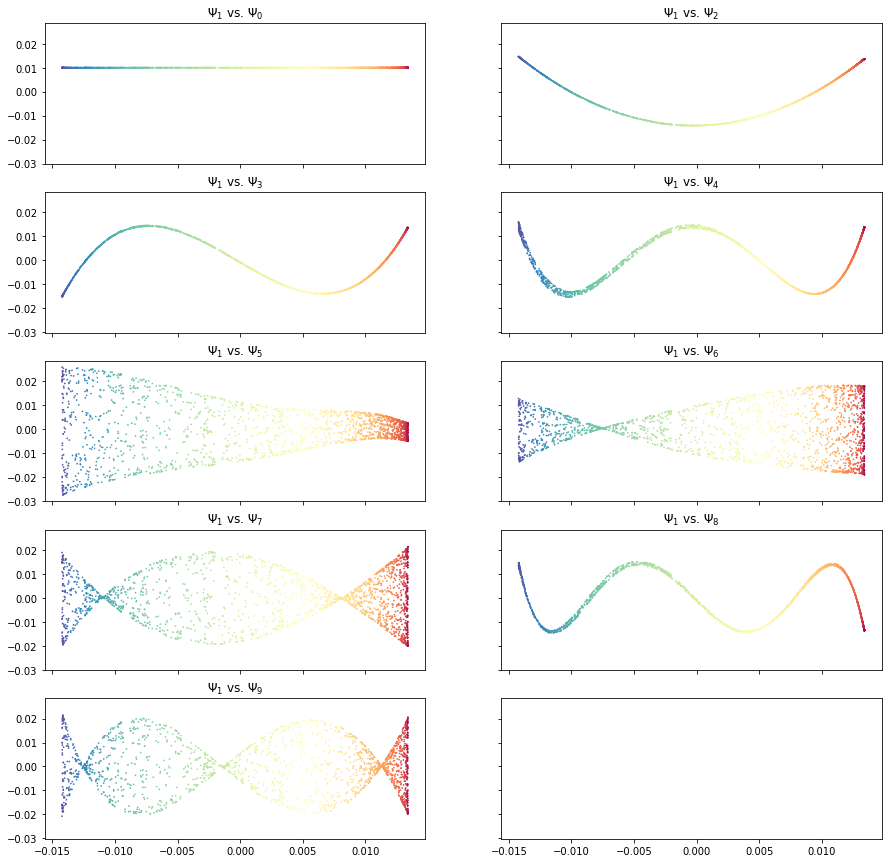

In [18]:
dmap = DiffusionMap()
evecs, evals = dmap.compute_eigenfunctions_datafold(positions, n_evecs)

# Plot the eigenfunction phi_1 with respect to the others
plot_eigenfunctions(n_evecs, nr_samples, nr_samples_plot, part, evecs, evals, positions_color)

### Part 3: Swiss-roll Data set embedding using Sklearn Isomap Library

In [32]:
def add_2d_scatter(ax, points, points_color, title=None):
    x, y = points.T
    ax.scatter(x, y, cmap=plt.cm.Spectral, c=points_color, s=0.5, alpha=0.8)
    ax.set_title(title)
    ax.xaxis.set_major_formatter(ticker.NullFormatter())
    ax.yaxis.set_major_formatter(ticker.NullFormatter())

In [33]:
def plot_2d(points, points_color, title):
    fig, ax = plt.subplots(figsize=(7, 4), facecolor="white", constrained_layout=True)
    fig.suptitle(title, size=16)
    add_2d_scatter(ax, points, points_color)
    plt.show()

In [36]:
n_neighbors = 20  # neighborhood which is used to recover the locally linear structure
n_components = 2  # number of coordinates for the manifold

In [37]:
isomap = manifold.Isomap(n_neighbors=n_neighbors, n_components=n_components, p=1)
S_isomap = isomap.fit_transform(positions)

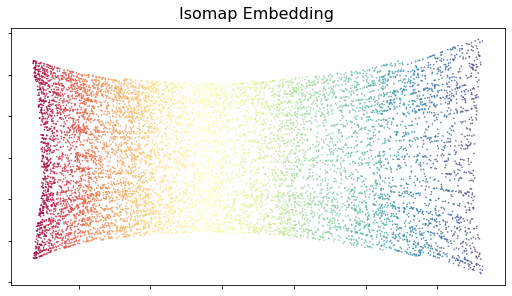

In [38]:
plot_2d(S_isomap, positions_color, "Isomap Embedding")

### Part 4: Swiss-roll Data set embedding using Megaman Isomap Library

In [52]:
from megaman.geometry import Geometry
from megaman.embedding import Isomap
import time

radius = 5
n_components = 2

In [53]:
adjacency_method = 'cyflann'
cyflann_kwds = {'index_type':'kmeans', 'branching':64, 'iterations':20, 'cb_index':0.4}
adjacency_kwds = {'radius':radius, 'cyflann_kwds':cyflann_kwds}
affinity_method = 'gaussian'
affinity_kwds = {'radius':radius}
laplacian_method = 'geometric'
laplacian_kwds = {'scaling_epps':radius}

geom = Geometry(adjacency_method=adjacency_method, adjacency_kwds=adjacency_kwds,
                affinity_method=affinity_method, affinity_kwds=affinity_kwds,
                laplacian_method=laplacian_method, laplacian_kwds=laplacian_kwds)

In [54]:
geom.set_data_matrix(positions)

In [55]:
t0 = time.time()
adjacency_matrix = geom.compute_adjacency_matrix()
t1 = time.time() - t0
print(t1)

0.10167527198791504


In [56]:
isomap = Isomap(n_components=n_components, eigen_solver='arpack',geom=geom)
embed_isomap = isomap.fit_transform(positions)

/home/erfan/anaconda3/envs/manifold_env/lib/python3.5/site-packages/sklearn/utils/validation.py:457: DeprecationWarning: Passing 'None' to parameter 'accept_sparse' in methods check_array and check_X_y is deprecated in version 0.19 and will be removed in 0.21. Use 'accept_sparse=False'  instead.
  " instead.", DeprecationWarning)
/home/erfan/anaconda3/envs/manifold_env/lib/python3.5/site-packages/megaman/embedding/isomap.py:23: RuntimeWarning: invalid value encountered in subtract
  K -= row_sums
/home/erfan/anaconda3/envs/manifold_env/lib/python3.5/site-packages/megaman/embedding/isomap.py:25: RuntimeWarning: invalid value encountered in add
  K += np.sum(row_sums)/N
/home/erfan/anaconda3/envs/manifold_env/lib/python3.5/site-packages/megaman/utils/eigendecomp.py:79: RuntimeWarning: invalid value encountered in less
  conditions = np.abs((M - M.T)) < tol


KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots()
ax.set_title('Isomap')
ax.scatter(embed_isomap[:, 0], embed_isomap[:, 1], s=1, c=positions_color)
ax.set_title('Spectral Embedding')
plt.show()